# HackRF Ultrasound Simulator

by William Meng K9TTL  
Aug 7, 2018

In this notebook, I will be demonstrating how to use the HackRF One software-defined radio (SDR)
as a signal source to emulate an ultrasound signal, as if it came from the analog frontend circuit of an ultrasound system.

We will be using data collected by kelu124 in his un0rick project.

In [1]:
%%bash
# Download CSV data from echomods
wget -nc https://raw.githubusercontent.com/kelu124/un0rick/master/images/20180403/p_A-130us-0-VGA%400x22-spimode1-64msps.csv

--2018-08-07 23:01:52--  https://raw.githubusercontent.com/kelu124/un0rick/master/images/20180403/p_A-130us-0-VGA%400x22-spimode1-64msps.csv
Resolving raw.githubusercontent.com... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 416000 (406K) [text/plain]
Saving to: ‘p_A-130us-0-VGA@0x22-spimode1-64msps.csv’

     0K .......... .......... .......... .......... .......... 12% 1.53M 0s
    50K .......... .......... .......... .......... .......... 24% 4.19M 0s
   100K .......... .......... .......... .......... .......... 36% 6.20M 0s
   150K .......... .......... .......... .......... .......... 49% 4.38M 0s
   200K .......... .......... .......... .......... .......... 61% 3.49M 0s
   250K .......... .......... .......... .......... .......... 73% 11.4M 0s
   300K .......... .......... .......... .......... .......... 86% 7.38M 0s
   350K .......... .......

The signal should like this:  
![example data from un0rick](https://raw.githubusercontent.com/kelu124/un0rick/master/images/20180403/p_A-130us-0-VGA%400x22-spimode1-64msps.jpg)

In the CSV file, each line contains a string representing a double-precision floating point number.
These numbers represent a discrete time signal $s[n]$ that is sampled from a real-valued signal $s(t)$.

Let's read the CSV file into a numpy array to represent $s[n]$:

first
s[n] at 64 Msps: [-6 -9 -8 ..., -7 -7 -6]
Num of samples: 8318


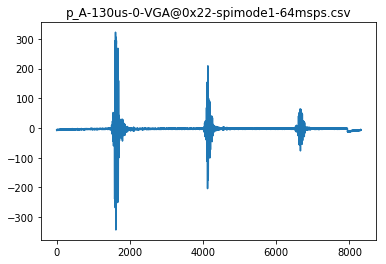

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import re

CSVFile = 'p_A-130us-0-VGA@0x22-spimode1-64msps.csv'
AA = []
lbl = []
IDLine = []

A = np.genfromtxt(CSVFile, delimiter=';').astype(int)[1:]
tmp = [] 
N = len(A)
FF = CSVFile.split(".")[0].split("-")[-1]
f = int(re.sub('[^0-9]','', FF))

if (A[4]) > 0b111:
    print("first")
    for i in range(int(len(A)/2-1)):
        value = 128*(A[2*i+0]&0b111) + A[2*i+1] - 512
        tmp.append( value ) 
else:
    print("second")
    for i in range(len(A)/2-1):
        value = 128*(A[2*i+1]&0b111) + A[2*i+2] - 512
        tmp.append( value )

t = [ 1.0*x/f for x in range(len(tmp))]

s_64M = np.array(tmp)
print("s[n] at 64 Msps: {}".format(s_64M))
print("Num of samples: {}".format(s_64M.size))
fig = plt.plot(s_64M)
plt.title(CSVFile)
plt.show()

Let's zoom in on a part of the signal:

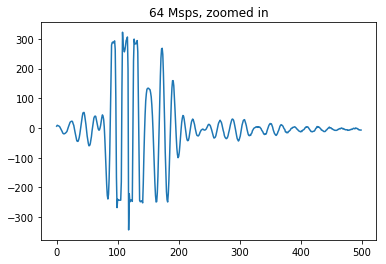

In [121]:
fig = plt.plot(s_64M[1500:2000])
plt.title("64 Msps, zoomed in")
plt.show()

We need to **decimate** the 64 Msps discrete time signal down to a sample rate supported by the HackRF, such as 16 Msps. This is done in two steps:
1. apply an anti alias filter (AAF) of half the sampling rate
2. downsample the resulting signal

We can use `scipy.signal.decimate()` to do this.

s[n] at 16 Msps: [-5.93299145 -6.63442809 -6.31772485 ..., -7.04515817 -6.60895118
 -6.01410309]
Num of samples: 2080


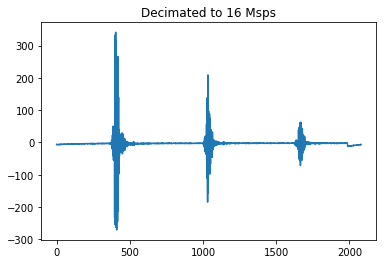

In [120]:
from scipy.signal import decimate
s_16M = decimate(s_64M, 4, zero_phase=True)
print("s[n] at 16 Msps: {}".format(s_16M))
print("Num of samples: {}".format(s_16M.size))
fig = plt.plot(s_16M)
plt.title("Decimated to 16 Msps")
plt.show()

The HackRF uses IQ samples, so we need to build a complex-valued signal $s_A(t)$
such that $Re\{s_A(t)\} = s(t)$.
This can be done by computing the **Hilbert transform** of the real signal, $\hat{s}(t)$.
Then $s_A(t) = s(t) + j\hat{s}(t)$.

In discrete time, we have $s_A[n] = s[n] + j\hat{s}[n]$.

Given $s[n]$, `scipy.signal.hilbert()` will return $s_A[n]$. I find this slightly misleading - the name suggests that it returns $\hat{s}(t)$, not $s_A[n]$. However, getting $\hat{s}(t)$ is done simply by extracting the imaginary component of $s_A[n]$.

s_A[n] at 16 Msps: [-5.93299145-0.814196j   -6.63442809-0.86035821j -6.31772485-0.7817786j
 ..., -7.04515817-1.37238235j -6.60895118-1.87804903j
 -6.01410309-1.67084413j]
^s[n] at 16 Msps: [-0.814196   -0.86035821 -0.7817786  ..., -1.37238235 -1.87804903
 -1.67084413]


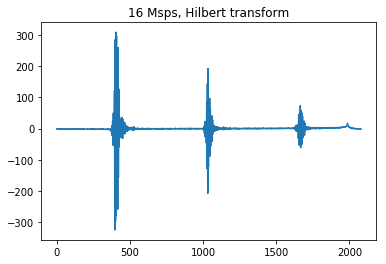

In [123]:
from scipy.signal import hilbert
s_A_16M = hilbert(s_16M)
print("s_A[n] at 16 Msps: {}".format(s_A_16M))
s_hilbert_16M = np.imag(s_A_16M)
print("^s[n] at 16 Msps: {}".format(s_hilbert_16M))
fig = plt.plot(s_hilbert_16M)
plt.title("16 Msps, Hilbert transform")
plt.show()

The IQ samples for the HackRF must be encoded as 8 bit signed integers.
So I and Q will simply be the mapping of $s[n]$ and $\hat{s}[n]$ onto the range of integers from -128 to 127.
To maximize the available dynamic range, the scale factor will be chosen so that
$ max\{|s[n]|, |\hat{s}[n]|\} \rightarrow 127 $.

In [125]:
max_real = np.amax(np.abs(s_16M))
max_imag = np.amax(np.abs(s_hilbert_16M))
maximum = max(max_real, max_imag)
scale_factor = 127 / maximum
print("Max of |s[n]|: {}".format(max_real))
print("Max of |^s[n]|: {}".format(max_imag))
print("Scale factor: {}".format(scale_factor))

Max of |s[n]|: 341.5685290727352
Max of |^s[n]|: 325.1524725226174
Scale factor: 0.3718141139781529


In [126]:
I = np.multiply(s_16M, scale_factor).astype('int8')
Q = np.multiply(s_hilbert_16M, scale_factor).astype('int8')
print("I: {}".format(I))
print("Q: {}".format(Q))

I: [-2 -2 -2 ..., -2 -2 -2]
Q: [0 0 0 ..., 0 0 0]


Now we can write our I and Q samples to a file for the `hackrf_transfer` program. 

In [128]:
# interleave I and Q
IQ = np.hstack(zip(I, Q))
print("IQ: {}".format(IQ))
# convert to bytearray
IQ_raw = IQ.tobytes()
print("0th element of IQ_raw: {}".format(IQ_raw[0]))
print("1st element of IQ_raw: {}".format(IQ_raw[1]))
# write bytes to file
IQ_filename = "ultrasoundIQ.s8"
IQ_file = open(IQ_filename, "wb")
n = IQ_file.write(IQ_raw)
print("Wrote {} bytes to file {}".format(n, IQ_filename))

IQ: [-2  0 -2 ...,  0 -2  0]
0th element of IQ_raw: 254
1st element of IQ_raw: 0
Wrote 4160 bytes to file ultrasoundIQ.raw


Now let's have some fun!